To build a good regression model, we checked data for missing values, multicollinearity, outliers, and normality.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from math import log, exp
from scipy.stats import norm, skew 


In [2]:
abspath = '/home/semipro321/Documents/Workspace/Geospatial-Analysis-on-House-Price-Prediction/'
df = pd.read_csv(abspath + 'Inputs/mastermodel_filled.csv')

In [3]:
df_nogeo = df.drop(columns=['lat', 'long', 'geometry'])

In [4]:
df_nogeo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15234 entries, 0 to 15233
Data columns (total 83 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sqft                        15234 non-null  float64
 1   parking                     15234 non-null  int64  
 2   mean_district_income        15234 non-null  int64  
 3   bedrooms_bg                 15234 non-null  int64  
 4   bedrooms_ag                 15234 non-null  int64  
 5   bathrooms                   15234 non-null  int64  
 6   final_price                 15234 non-null  int64  
 7   type_Att/Row/Twnhouse       15234 non-null  int64  
 8   type_Co-Op Apt              15234 non-null  int64  
 9   type_Co-Ownership Apt       15234 non-null  int64  
 10  type_Comm Element Condo     15234 non-null  int64  
 11  type_Condo Apt              15234 non-null  int64  
 12  type_Condo Townhouse        15234 non-null  int64  
 13  type_Detached               152

Convert neighboorhood into dummy

In [5]:
df_nogeo = pd.get_dummies(df_nogeo, columns=['neighbourhood'])
df_nogeo.shape

(15234, 222)

Check for multicollinearity -  pearson correlation (r>0.9)

In [6]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_nogeo, 30))

Top Absolute Correlations
Assault_2015_1000m  Assault_2016_1000m    0.994365
Assault_2016_1000m  Assault_2017_1000m    0.994110
Assault_2014_1000m  Assault_2015_1000m    0.994056
Assault_2015_1000m  Assault_2017_1000m    0.993865
Assault_2017_1000m  Assault_2018_1000m    0.993755
Assault_2018_1000m  Assault_2019_1000m    0.993489
Assault_2014_1000m  Assault_2016_1000m    0.991993
Assault_2016_1000m  Assault_2018_1000m    0.990431
Assault_2014_1000m  Assault_2017_1000m    0.989653
Assault_2016_500m   Assault_2017_500m     0.988411
Assault_2015_1000m  Assault_2018_1000m    0.987831
Assault_2014_500m   Assault_2015_500m     0.986216
Assault_2015_500m   Assault_2016_500m     0.985393
Assault_2017_1000m  Assault_2019_1000m    0.985198
Assault_2014_1000m  Assault_2018_1000m    0.984653
Assault_2018_500m   Assault_2019_500m     0.984619
Assault_2014_500m   Assault_2016_500m     0.984575
Assault_2017_500m   Assault_2018_500m     0.984567
Assault_2015_500m   Assault_2017_500m     0.984185
Assau

gotta fix this => Goig to combine them

In [7]:
col_sub1000 = []
for i in range(2014, 2020):
    col_sub1000.append(f'Assault_{i}_1000m')
    col_sub1000.append(f'Auto Theft_{i}_1000m')
    col_sub1000.append(f'Break and Enter_{i}_1000m')
    col_sub1000.append(f'Robbery_{i}_1000m')
    col_sub1000.append(f'Theft Over_{i}_1000m')

col_sub500 = []
for i in range(2014, 2020):
    col_sub500.append(f'Assault_{i}_500m')
    col_sub500.append(f'Auto Theft_{i}_500m')
    col_sub500.append(f'Break and Enter_{i}_500m')
    col_sub500.append(f'Robbery_{i}_500m')
    col_sub500.append(f'Theft Over_{i}_500m')


In [8]:
for i in col_sub500:
    df_nogeo[i[:-10]+'500m'] = 0
for i in col_sub500:
    df_nogeo[i[:-10]+'500m'] += df_nogeo[i]

In [9]:
for i in col_sub1000:
    df_nogeo[i[:-11]+'1000m'] = 0
for i in col_sub1000:
    df_nogeo[i[:-11]+'1000m'] += df_nogeo[i]

In [10]:
df_nogeo.drop(columns=col_sub1000 + col_sub500, inplace=True)

In [11]:
df_nogeo.shape

(15234, 172)

In [12]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_nogeo, 30))

Top Absolute Correlations
Assault1000m          Break and Enter1000m    0.958617
                      Theft Over1000m         0.946866
                      Robbery1000m            0.938862
Break and Enter1000m  Theft Over1000m         0.931372
Break and Enter500m   Break and Enter1000m    0.921427
Assault500m           Break and Enter500m     0.915315
                      Robbery500m             0.906231
                      Assault1000m            0.898056
Break and Enter1000m  Robbery1000m            0.889532
Break and Enter500m   Assault1000m            0.889139
                      Theft Over1000m         0.886146
Assault500m           Break and Enter1000m    0.877721
                      Theft Over1000m         0.876778
Break and Enter500m   Theft Over500m          0.864586
Assault500m           Theft Over500m          0.862525
Robbery500m           Robbery1000m            0.857418
sqft                  bathrooms               0.851843
Assault500m           Robbery1000m     

Assault + B&E + Robbery -> High correlated  

Theft + Robbery -> High correlated  

Should we absorb: Assault + B&E + Robbery + Theft  

In [13]:
df_nogeo['violent_crime1000m'] = df_nogeo['Assault1000m'] + df_nogeo['Break and Enter1000m'] + df_nogeo['Robbery1000m'] + df_nogeo['Break and Enter1000m'] +df_nogeo['Theft Over1000m']
df_nogeo['violent_crime500m'] = df_nogeo['Assault500m'] + df_nogeo['Break and Enter500m'] + df_nogeo['Robbery500m'] + df_nogeo['Break and Enter500m'] + df_nogeo['Theft Over500m']
df_nogeo.drop(columns=['Assault1000m', 'Break and Enter1000m', 'Robbery1000m', 'Break and Enter1000m', 'Assault500m', 'Break and Enter500m', 'Robbery500m', 'Break and Enter500m', 'Theft Over500m', 'Theft Over1000m'], inplace=True)

In [14]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_nogeo, 30))

Top Absolute Correlations
violent_crime1000m                   violent_crime500m                       0.921934
sqft                                 bathrooms                               0.851843
Airbnb_500m                          Airbnb_1000m                            0.844417
Auto Theft1000m                      violent_crime1000m                      0.840195
sqft                                 bedrooms_ag                             0.821701
                                     final_price                             0.773309
Auto Theft1000m                      violent_crime500m                       0.766442
bedrooms_ag                          bathrooms                               0.745654
                                     type_Condo Apt                          0.700964
Auto Theft500m                       violent_crime500m                       0.686594
bathrooms                            final_price                             0.674345
type_Condo Apt              

In [19]:
df_nogeo.to_csv('mastermodel_filledv2.csv', index = False)

500m & 1000m High correlated=> Maybe make distance further? Or absorb it?

In [15]:
for i in df_nogeo.columns:
    print(i)

sqft
parking
mean_district_income
bedrooms_bg
bedrooms_ag
bathrooms
final_price
type_Att/Row/Twnhouse
type_Co-Op Apt
type_Co-Ownership Apt
type_Comm Element Condo
type_Condo Apt
type_Condo Townhouse
type_Detached
type_Link
type_Plex
type_Semi-Detached
type_Store W/Apt/Offc
dist_nearest_school
dist_nearest_ttc
Airbnb_500m
Airbnb_1000m
neighbourhood_Agincourt North
neighbourhood_Agincourt South-Malvern West
neighbourhood_Alderwood
neighbourhood_Annex
neighbourhood_Banbury-Don Mills
neighbourhood_Bathurst Manor
neighbourhood_Bay Street Corridor
neighbourhood_Bayview Village
neighbourhood_Bayview Woods-Steeles
neighbourhood_Bedford Park-Nortown
neighbourhood_Beechborough-Greenbrook
neighbourhood_Bendale
neighbourhood_Birchcliffe-Cliffside
neighbourhood_Black Creek
neighbourhood_Blake-Jones
neighbourhood_Briar Hill-Belgravia
neighbourhood_Bridle Path-Sunnybrook-York Mills
neighbourhood_Broadview North
neighbourhood_Brookhaven-Amesbury
neighbourhood_Cabbagetown-South St.James Town
neighbourh

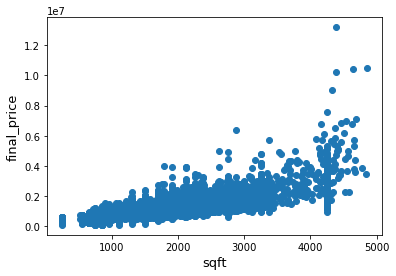

In [16]:
fig, ax = plt.subplots()
ax.scatter(x = df_nogeo['sqft'], y = df_nogeo['final_price'])
plt.ylabel('final_price', fontsize=13)
plt.xlabel('sqft', fontsize=13)
plt.show()

Few outliers 

/home/semipro321/anaconda3/envs/dataenv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='final_price', ylabel='Density'>

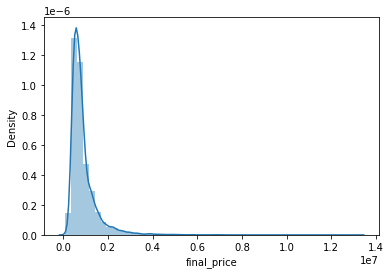

In [17]:
sns.distplot(df_nogeo['final_price'])

/home/semipro321/anaconda3/envs/dataenv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='final_price', ylabel='Density'>

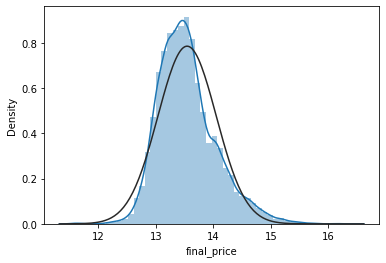

In [18]:
sns.distplot(df_nogeo['final_price'].apply(lambda x: log(x)), fit=norm)

Lets log transform final prices

In [ ]:
# df_nogeo['final_price'] = df_nogeo['final_price'].apply(lambda x: log(x))

In [ ]:
numeric_feats = df_nogeo.dtypes[df_nogeo.dtypes != "object"].index

skewed_feats = df_nogeo[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df_nogeo[feat] = boxcox1p(df_nogeo[feat], lam)

In [ ]:
from sklearn.model_selection import train_test_split
# X = df_nogeo.drop('final_price', axis=1).values
# y = df_nogeo['final_price'].values
train, test  = train_test_split(df_nogeo, test_size=0.20, random_state=42)


In [ ]:
train['final_price'].apply(lambda x: exp(x))

Now returning to fix outlier of training dataset

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train['sqft'], y = train['final_price'])
plt.ylabel('final_price', fontsize=13)
plt.xlabel('sqft', fontsize=13)
plt.show()

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb